In [1]:
import xarray as xr # Import the Xarray package
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Import the Numpy package
import cartopy,cartopy.crs as ccrs # Plot maps
import cartopy.feature as cfeature # Collection of points, lines and polygons
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER # Add gridlines and tick labels to a map
import cartopy.io.shapereader as shpreader # Oriented shapefile reader
from netCDF4 import Dataset # Read/Write NetCDF4 files
from datetime import datetime, timedelta # Basics Dates and time types
from matplotlib import cm # Colormap handling utilities
import metpy
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from utilities import loadCPT
from scipy.ndimage.filters import maximum_filter, minimum_filter
import scipy.ndimage as ndimage
from ecmwf.opendata import Client

In [2]:
ds13=xr.open_dataset('C:/Users/igorr/Downloads/OR_ABI-L2-CMIPF-M6C08_G16_s20233090150206_e20233090159514_c20233090159578.nc')
ds13

<xarray.Dataset>
Dimensions:                                           (y: 5424, x: 5424, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1518 ... ...
  * x                                                 (x) float32 -0.1518 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    band_wavelength                                   (band) float32 ...
    band_id                                           (band) int32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band
Data variables: (12/35)
    CMI                                               (y, x) float32 ...
    DQF                                               (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    y_image_bounds                                    (number_of_image_bounds) float32 ...
    x_image_bounds                                    (number_of_image_bounds) float32 ...
    ...                                                ...
    focal_plane_temperature_threshold_exceeded_count  float64 ...
    maximum_focal_plane_temperature                   float32 ...
    focal_plane_temperature_threshold_increasing      float32 ...
    focal_plane_temperature_threshold_decreasing      float32 ...
    channel_integration_time                          float64 ...
    channel_gain_field                                float64 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-11-05T01:50:20.6Z
    time_coverage_end:         2023-11-05T01:59:51.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        73610513-2054-4023-82aa-5dd977976a12

In [3]:
dat13 = ds13.metpy.parse_cf('CMI')
dat13=dat13-273.15
geos = dat13.metpy.cartopy_crs

x = dat13.x
y = dat13.y

In [4]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(ds13.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
date=scan_start
# Scan's end time, converted to datetime object
scan_end = datetime.strptime(ds13.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(ds13.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(ds13['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2023-11-05 01:50:20.600000
Scan midpoint : 2023-11-05 01:55:06
Scan End      : 2023-11-05 01:59:51.400000
File Created  : 2023-11-05 01:59:57.800000
Scan Duration : 9.50 minutes


In [5]:
cpt=loadCPT('WVCOLOR35.cpt')
my_cmap=cm.colors.LinearSegmentedColormap('cpt',cpt)
vmin=-103.15
vmax=106.85

In [6]:
x,y=np.meshgrid(dat13.x,dat13.y)

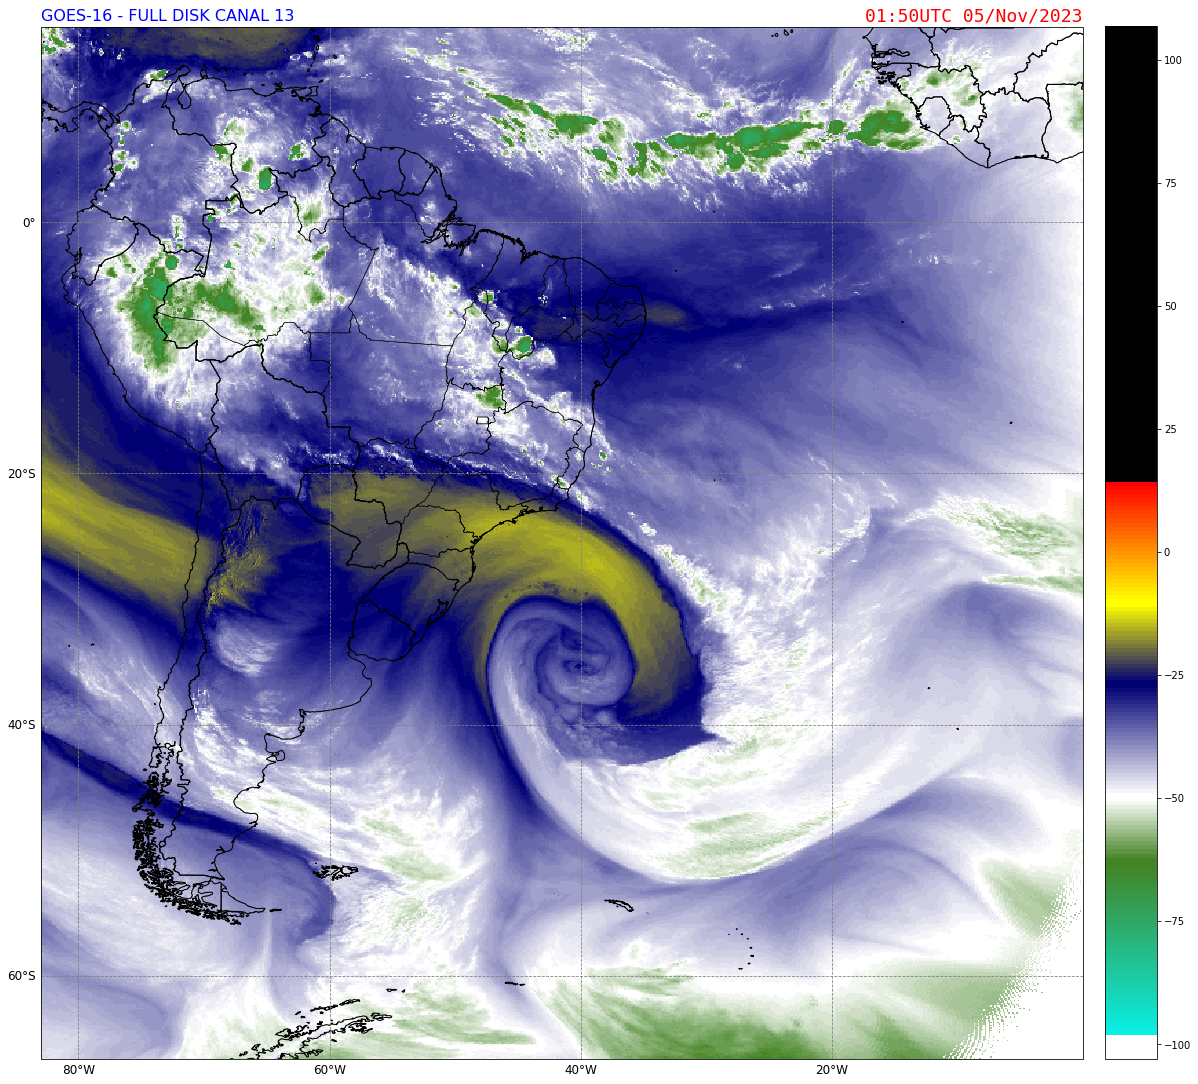

In [7]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m",edgecolor='k',linestyle='-',linewidth=0.3)
#ax.set_extent([-83,-34,12,-54])
#ax.set_extent([-58,-47,-34,-22])
ax.set_extent([-83,0,12,-60])
#ax.set_extent([-105,-95,21,14])
##ax.set_extent([-54.8,-47.9,-22.4,-26.8])
##ax.set_extent([-58, -48, -22, -34])
im=ax.imshow(dat13,#cmap='gray_r',
             cmap=my_cmap,
             vmin=vmin,vmax=vmax,
             origin='upper',
             extent=(x.min(), x.max(), y.min(), y.max()),
             transform=geos,
             interpolation='none')

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=1.)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=0.5)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.0463,orientation='vertical')
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.043,orientation='horizontal')
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.0332,orientation='vertical')
##cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.0305,orientation='vertical')
plt.title('GOES-16 - FULL DISK CANAL 13',
          fontsize=16,loc='left',color='blue')
#plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC')),fontsize=18,loc='right',
#          color='blue',fontweight='normal',fontfamily='monospace')
plt.title('{}'.format(scan_start.strftime('%H:%MUTC %d/%b/%Y')),fontsize=18,loc='right',
          color='red',fontweight='normal',fontfamily='monospace')
plt.savefig('GOES16_CH8_WV_AS_'+scan_start.strftime('%H_%MUTC_%d_%b_%Y')+'.jpeg',dpi=300,bbox_inches='tight')